In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import scipy
import seaborn as sns
from datetime import datetime, timedelta

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

In [2]:
from lstm import LSTM
from preprocessing import *
from utils import *
from features import *

In [3]:
raw_data = pd.read_csv('consumption_and_temperatures.csv')
raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'])

In [4]:
seq_len = 72
scale_output=True
target_column = 'NO1_consumption'

In [5]:
features_to_add = [
    (   
        pick_location_data,
        { 'loc': [1] }
    ),
    (
        add_season_columns, 
        {}
    ),
    (
        shift_data, 
        {
            "shift_max": 10,
            "column_to_shift": "NO1_temperature",
            "new_column_name": "temp"
        }
    ),
    (
        shift_data, 
        {   
            # "shift_min": 24,
            "shift_max": 1,
            "column_to_shift": "NO1_consumption",
            "new_column_name": "consum"
        },
    ),
    # (
    #     change_timestamp_to_sin,
    #     {}
    # ),
    (
        add_hour_columns,
        {}
    )
]
# features_to_add=[(add_season_columns, {}), (pick_location_data, {'loc': [1]})]


In [6]:
for feature in features_to_add:
    print(feature)

(<function pick_location_data at 0x169c155a0>, {'loc': [1]})
(<function add_season_columns at 0x169c153f0>, {})
(<function shift_data at 0x169c15630>, {'shift_max': 10, 'column_to_shift': 'NO1_temperature', 'new_column_name': 'temp'})
(<function shift_data at 0x169c15630>, {'shift_max': 1, 'column_to_shift': 'NO1_consumption', 'new_column_name': 'consum'})
(<function add_hour_columns at 0x169c15480>, {})


In [7]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), (scalerInputMethod, scalerOutputMethod), (df_target, time_delta_shifting) = general_preprocessing(
        raw_data, 
        features_to_add=features_to_add,
        seq_len=seq_len,
        scale_output=scale_output
    )

FEATURES:
 Index(['NO1_temperature', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'temp_1_previous', 'temp_2_previous',
       'temp_3_previous', 'temp_4_previous', 'temp_5_previous',
       'temp_6_previous', 'temp_7_previous', 'temp_8_previous',
       'temp_9_previous', 'temp_10_previous', 'consum_1_previous', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')


/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[features_to_scale] = scalerInputMethod.fit_transform(X_train[features_to_scale].values) if not is_scaler_fitted else  scalerInputMethod.transform(X_train[features_to_scale].values)
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [9]:
input_size = X_train.shape[2]
hidden_size = 11
num_layers = 3

model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

In [10]:
lr = 1e-3
num_epochs=300

In [11]:
loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=lr)

In [12]:
model, losses, val_loss, opt = fit(
    model, 
    train_set=(X_train, y_train),
    val_set=(X_val, y_val),
    opt=opt,
    loss_func=loss_func,
    num_epochs=num_epochs
)

100%|██████████| 300/300 [21:29<00:00,  4.30s/it]


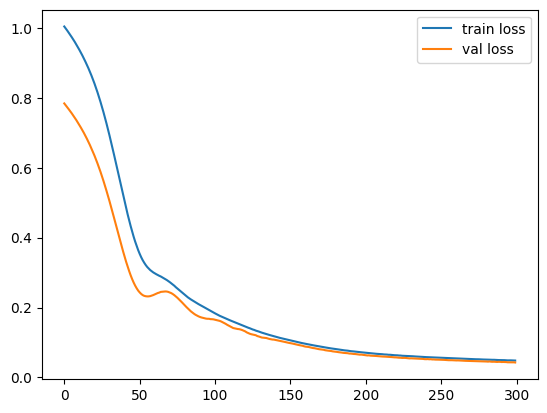

In [13]:
plt.plot(losses, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()

In [14]:
y_test, y_pred = predict(model, scalerOutputMethod, (X_test, y_test))

In [15]:
y_test.shape, y_pred.shape

((5848,), (5848,))

In [20]:
time_delta_shifting

10

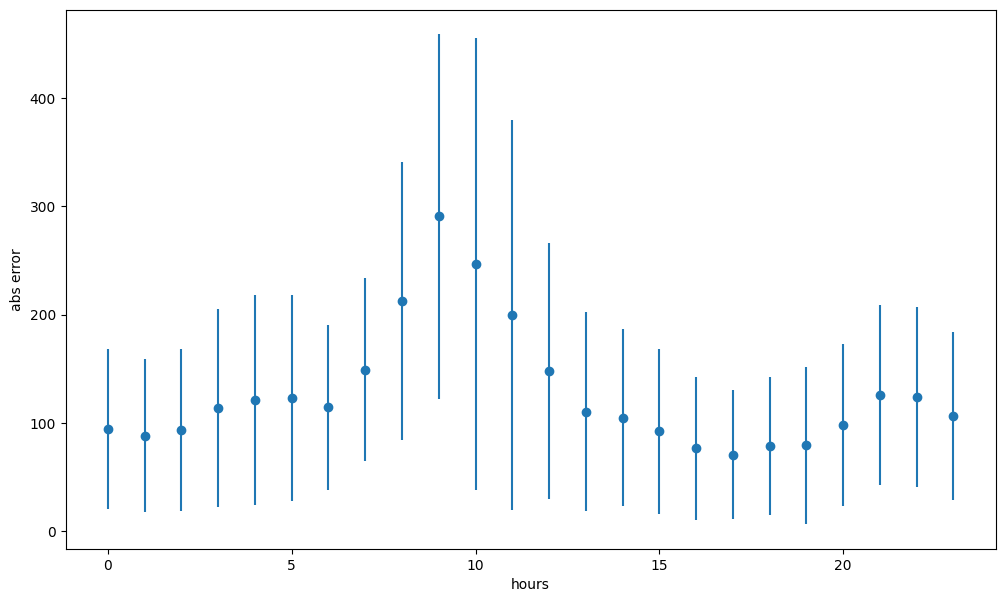

In [16]:
plot_error_by_hour_for_test_set(y_test, y_pred)

In [23]:
seq_len, time_delta_shifting

(72, 10)

In [25]:
def make_forecast(
        y_pred: torch.Tensor, 
        df_target: pd.DataFrame, 
        seq_len: int = 0, 
        forecast_duration: int = 24, 
        time_delta_shifting: int = 0
    ) -> None:
    index_start_forecast = np.random.randint(0, len(y_pred))
    dt = np.max([time_delta_shifting, seq_len])
    forecast_array = y_pred[index_start_forecast:index_start_forecast+ forecast_duration]
    x_axis_forecast = df_target[index_start_forecast + dt:index_start_forecast + dt + forecast_duration]['timestamp']

    df_forecast = pd.DataFrame({
        'timestamp': x_axis_forecast.values, 
        'consumption_forecast': forecast_array
        })
    df_forecast.index = x_axis_forecast.index

    df_result = df_target[index_start_forecast:index_start_forecast + dt + forecast_duration]
    df_result['forecast'] = df_forecast['consumption_forecast']

    df_result.set_index('timestamp').plot(figsize=(10,5))
    plt.legend()
    plt.show()

/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_98026/630330670.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


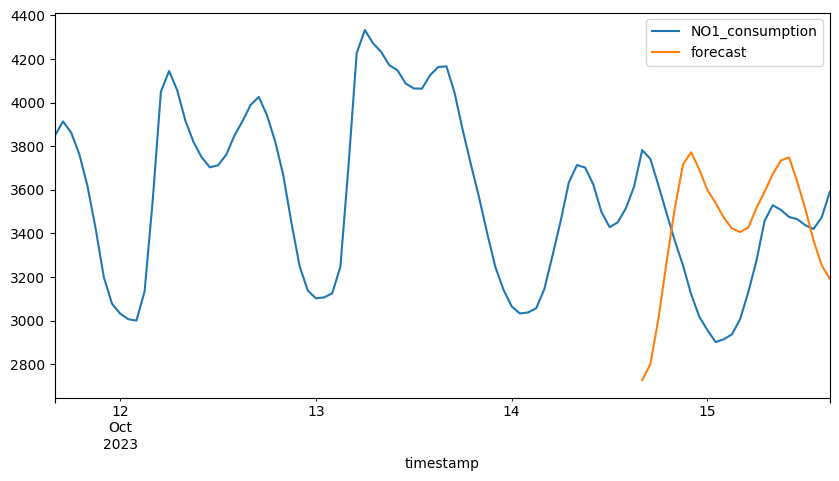

/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_98026/630330670.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


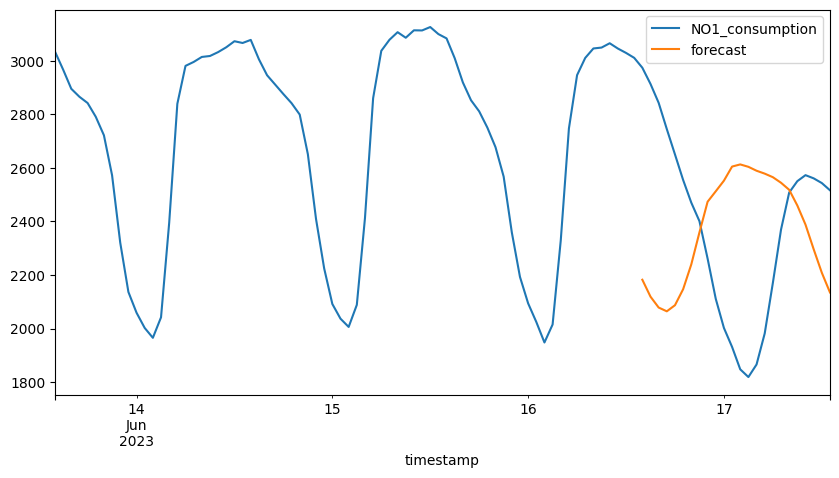

/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_98026/630330670.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


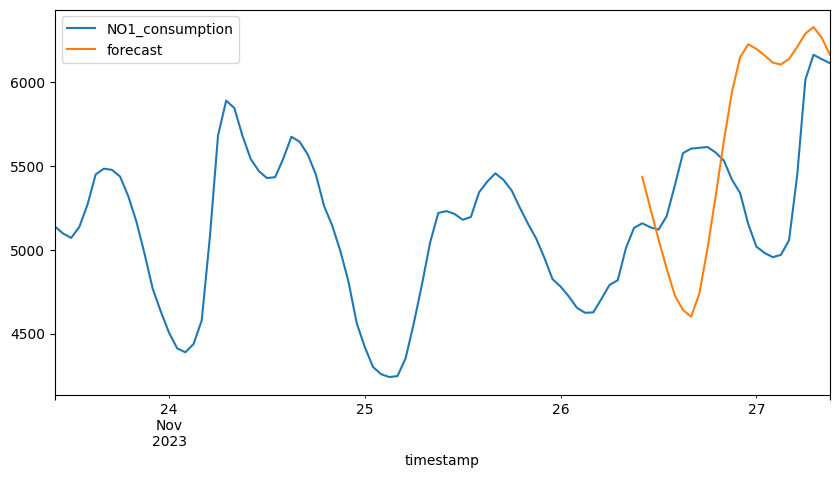

/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_98026/630330670.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


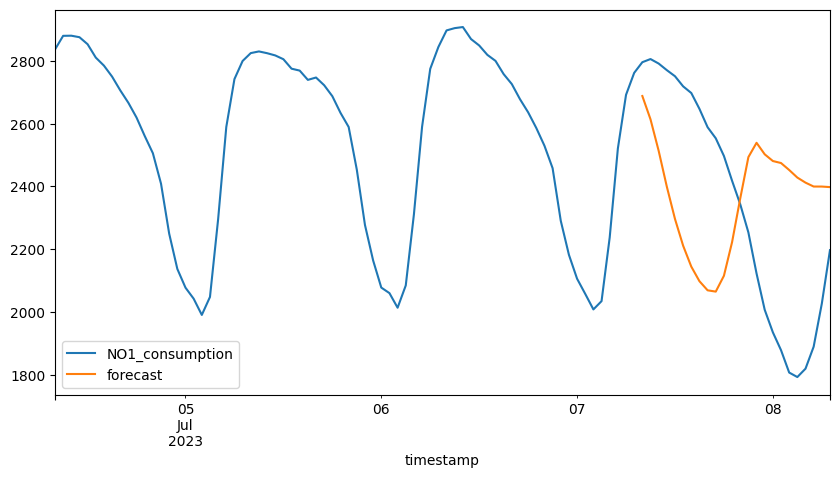

/var/folders/dv/nzlg6jm168311nq7f93wfrd80000gn/T/ipykernel_98026/630330670.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


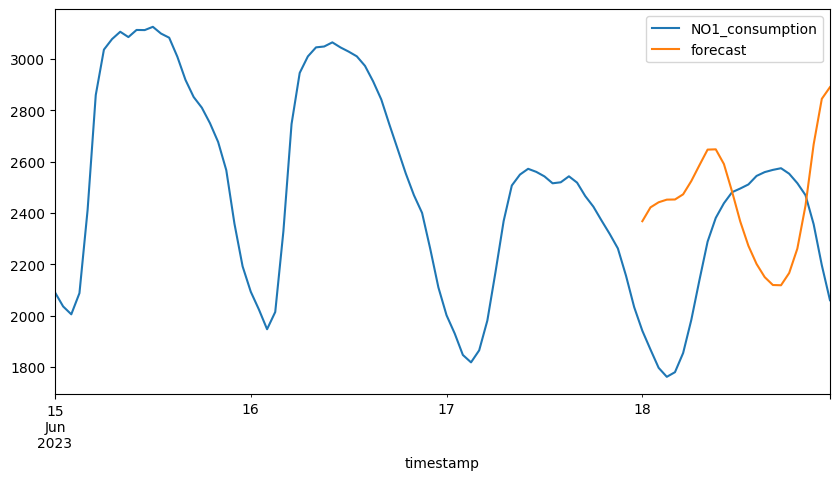

In [26]:
for k in range(5):
    make_forecast(y_pred=y_pred, df_target=df_target, seq_len=seq_len, time_delta_shifting=time_delta_shifting)